## (1) Import libraries

In [1]:
from pycaret.datasets import get_data
from pycaret.regression import *

In [2]:
# Record version of key libraries
from importlib.metadata import version

print('pycaret==%s' % version('pycaret'))

pycaret==2.3.1


## (2) Get data

In [3]:
# Get a list of all pre-packaged data
# get_data('index')

# Select a pre-packaged data for testing
data = get_data('diamond')

Carat Weight    Cut Color Clarity Polish Symmetry Report  Price
0          1.10  Ideal     H     SI1     VG       EX    GIA   5169
1          0.83  Ideal     H     VS1     ID       ID   AGSL   3470
2          0.85  Ideal     H     SI1     EX       EX    GIA   3183
3          0.91  Ideal     E     SI1     VG       VG    GIA   4370
4          0.83  Ideal     G     SI1     EX       EX    GIA   3171

## (3) Setup pipeline

This step also includes data pre-processing steps such as normalisation and missing values imputation.

Logged data and profile are stored under `mlruns` folder.

In [7]:
# Get relevant column names
numeric_cols = [
    'Carat Weight'
]
categorical_cols = [
    'Cut', 
    'Color', 
    'Clarity', 
    'Polish', 
    'Symmetry', 
    'Report'
]
ignore_cols = []

# Setup core pycaret config
clf_setup = setup(
    data=data, 
    target='Price', 
    silent=True,
    numeric_features=numeric_cols,
    categorical_features=categorical_cols,
    ignore_features=ignore_cols,
    imputation_type='simple',
    numeric_imputation='median',
    normalize=True,
    normalize_method='minmax',
    n_jobs=-1,
    preprocess=True,
    session_id=6, 
    log_data=True,
    log_profile=True,
    log_experiment=True, 
    experiment_name='diamond1')

# Retrieve and save processed data
X_data = get_config('X')
y_data = get_config('y')
y_data.name = 'Target variable'
comb_data = X_data.merge(y_data, left_index=True, right_index=True)
comb_data.to_csv('./processed_data.csv', index=False)

# data_processing_pipeline = get_config('prep_pipe')


## (4) Compare models

In [10]:
# Select a list of models of interest to be tested
# # To see all available models
# models()

# Pick logistic regression & ensemble models
chosen_model_types_list = ['lr'] + models(type='ensemble').index.tolist()

top3_models = compare_models(
    include = chosen_model_types_list, 
    n_select = 3,
    sort = 'MAE',
    errors='raise'
)

print(top3_models)

[LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=6, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0), ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=6, verbose=0, warm_start=False), RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse'

## (5) Tune models

In [11]:
# Tune top models

tuned_top3_models = [
    tune_model(
        i, 
        optimize='MAE',
        search_library='tune-sklearn',
        search_algorithm='hyperopt',
        choose_better=True
    ) 
    for i in top3_models]

print(tuned_top3_models)

[LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=6, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0), ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=6, verbose=0, warm_start=False), RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse'

## (6) Combine multiple models

In [13]:
# Blend top tuned models into a single voting regressor model

blended_model = blend_models(
    estimator_list = tuned_top3_models
)

print(blended_model)

VotingRegressor(estimators=[('lightgbm',
                             LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=6,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silent=True, subsam...
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alph

## (7) Analyze model performance

In [14]:
# Make interactive standard diagnostic plots
evaluate_model(blended_model)

# plot_model(blended_model, plot='residuals_interactive')
# plot_model(blended_model, plot='error')
# plot_model(blended_model, plot='learning')
# plot_model(blended_model, plot='manifold')
# # plot_model(blended_model, plot='feature')

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## (8) Interpret models

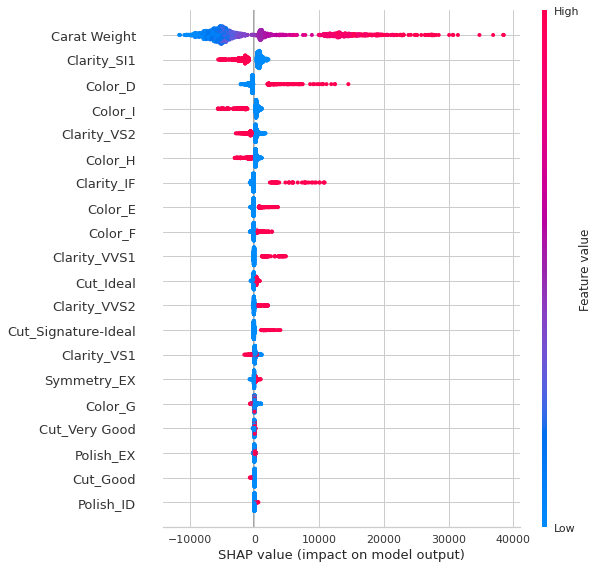

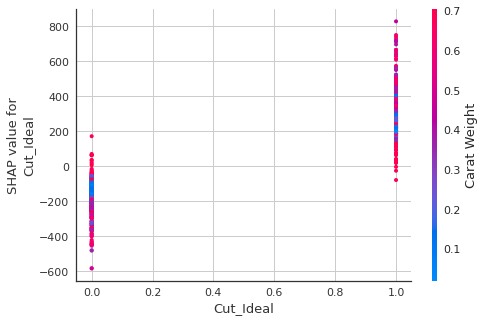

In [16]:
# Interpret model - only for tree-based models

interpret_model(tuned_top3_models[0], plot='summary')
interpret_model(tuned_top3_models[0], plot='correlation', feature='Cut_Ideal')
interpret_model(tuned_top3_models[0], plot='reason', observation=100)

## (9) Select best model automatically

In [17]:
# Select best model out of all models trained in current session

best_model = automl(optimize = 'MAE')

print(best_model)

VotingRegressor(estimators=[('lightgbm',
                             LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=6,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silent=True, subsam...
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alph

In [18]:
# Final check on performance of best model

compare_models(
    include = [best_model] + tuned_top3_models, 
    sort='MAE',
    errors='raise'
)

VotingRegressor(estimators=[('lightgbm',
                             LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=6,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silent=True, subsam...
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alph

## (10) Save best model

In [19]:
# Save model

save_model(best_model, model_name='best_model')
# best_model = load_model('best_model')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['Cut', 'Color',
                                                             'Clarity', 'Polish',
                                                             'Symmetry',
                                                             'Report'],
                                       display_types=False, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['Carat Weight'],
                                       target='Price', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_v...
                                                                     ccp_alpha=0.0,
                                                                     criterion='mse',
                      